In [4]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

filepath = r'/content/seaice_data.csv'
seaice = pd.read_csv(filepath)
seaice.head()

,Extent_north,Datetime,Extent_south,Extent_total
0,10.231,1978-10-26,17.624,27.855
1,10.420,1978-10-28,17.803,28.223
2,10.557,1978-10-30,17.670,28.227
3,10.670,1978-11-01,17.527,28.197
4,10.777,1978-11-03,17.486,28.263


In [5]:
# somehow date has been converted back to str in the .csv
# fix that
seaice['date'] = pd.to_datetime(seaice['Datetime'])
seaice.drop(columns=['Datetime'])

,Extent_north,Extent_south,Extent_total,date
0,10.231,17.624,27.855,1978-10-26
1,10.420,17.803,28.223,1978-10-28
2,10.557,17.670,28.227,1978-10-30
3,10.670,17.527,28.197,1978-11-01
4,10.777,17.486,28.263,1978-11-03
...,...,...,...,...
14918,14.784,2.809,17.593,2024-03-07
14919,14.828,2.873,17.701,2024-03-08
14920,14.879,2.924,17.803,2024-03-09
14921,14.968,2.985,17.953,2024-03-10


In [6]:
# create an index for resampling
seaice.set_index('date', inplace=True)

# resample for monthly to work for seasonality
monthly_means = seaice.resample('M').mean()
print(monthly_means)

            Extent_north  Extent_south  Extent_total
date                                                
1978-10-31     10.402667     17.699000     28.101667
1978-11-30     11.645133     15.896400     27.541533
1978-12-31     13.667063     10.395250     24.062313
1979-01-31     15.414000      5.402200     20.816200
1979-02-28     16.175286      3.141071     19.316357
...                  ...           ...           ...
2023-11-30      9.659367     14.272467     23.931833
2023-12-31     12.003000      8.667903     20.670903
2024-01-31     13.916419      3.961452     17.877871
2024-02-29     14.606655      2.141690     16.748345
2024-03-31     14.827545      2.716364     17.543909

[546 rows x 3 columns]


<ipython-input-6-2d95a6238996>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_means = seaice.resample('M').mean()


In [7]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# set up train/test split to see reliability of model
# first let's use only 'Extent_total'
seaice_1 = monthly_means.drop(columns=['Extent_north','Extent_south'])
print(seaice_1)

            Extent_total
date                    
1978-10-31     28.101667
1978-11-30     27.541533
1978-12-31     24.062313
1979-01-31     20.816200
1979-02-28     19.316357
...                  ...
2023-11-30     23.931833
2023-12-31     20.670903
2024-01-31     17.877871
2024-02-29     16.748345
2024-03-31     17.543909

[546 rows x 1 columns]


In [8]:
# separate into train/test split
train = seaice_1[:'2022-03-31']
print(len(train))
test = seaice_1['2022-04-30':]
print(len(test))



522
24


In [9]:
# create and fit TES model
model = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12)

fit_model = model.fit()

# print parameters
print("Fitted smoothing parameters:")
print("Smoothing level:", fit_model.params['smoothing_level'])
print("Smoothing trend:", fit_model.params['smoothing_trend'])
print("Smoothing seasonal:", fit_model.params['smoothing_seasonal'])
print("Initial level:", fit_model.params['initial_level'])
print("Initial trend:", fit_model.params['initial_trend'])
print("Initial seasonal:", fit_model.params['initial_seasons'])

Fitted smoothing parameters:
Smoothing level: 0.9999999850819019
Smoothing trend: 4.159713260121085e-12
Smoothing seasonal: 3.347950308710491e-09
Initial level: 22.1384265092841
Initial trend: -0.006801089319942087
Initial seasonal: [1.26975263 1.28020965 1.1235619  0.93446912 0.88365735 0.93828436
 1.04035237 1.13351266 1.2134185  1.22320318 1.19780127 1.19647644]


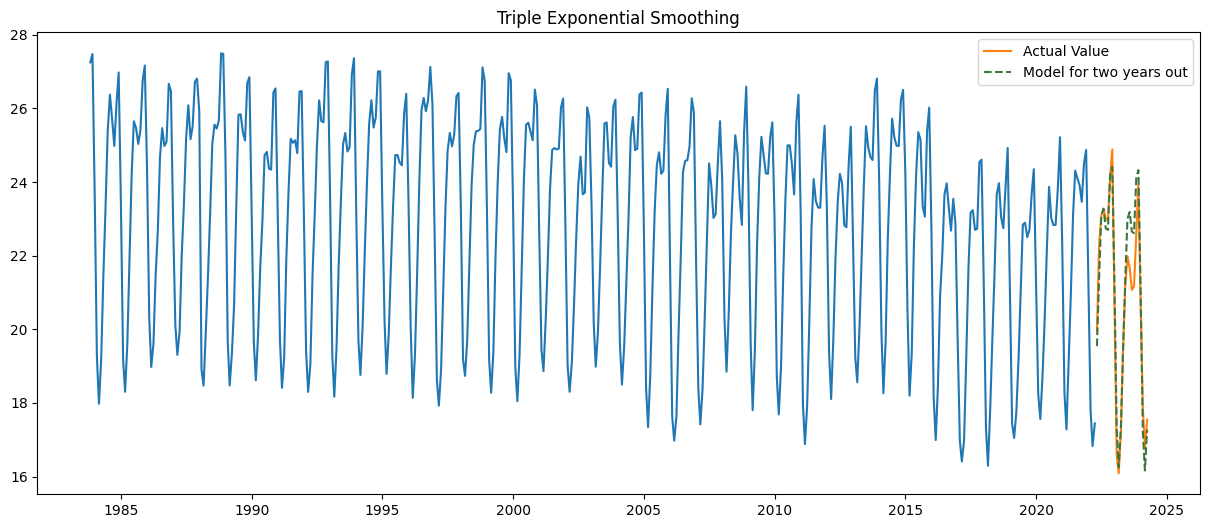

In [16]:
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)

fit = model.fit()
pred = fit.forecast(24)


model1 = np.sqrt(np.mean(np.square(test.values - pred.values)))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='Actual Value');
ax.plot(test.index, pred, linestyle='--', color='#3c763d', label="Model for two years out".format(model1, fit.aic));
ax.legend();
ax.set_title("Triple Exponential Smoothing");

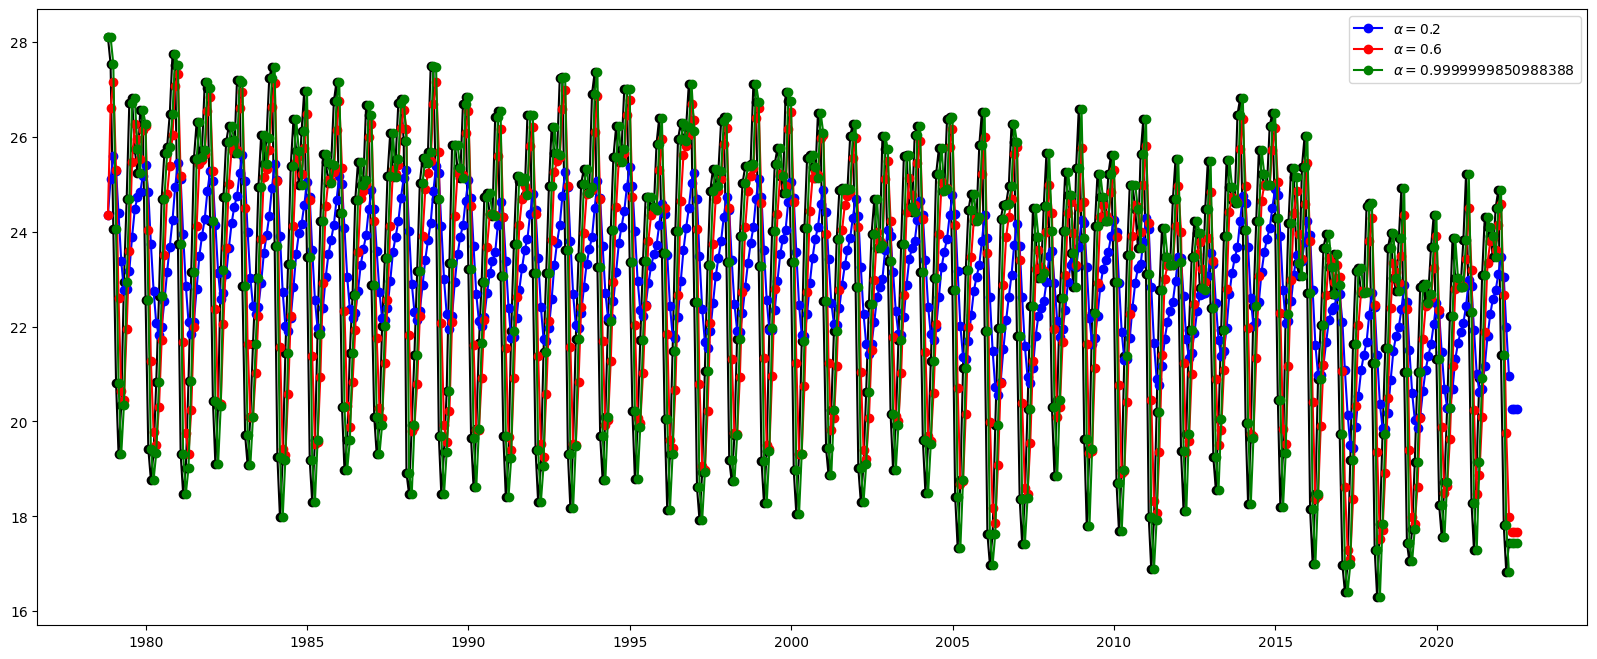

In [17]:
#testing different alphas for simple exponential smoothing
#can see that lower alphas have less change per point, maybe not great for this type of data as it can change pretty drastically from month to month

fit1 = SimpleExpSmoothing(train, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(train, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])


plt.figure(figsize=(20, 8))
plt.plot(train, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [20]:
# let's create a forecast that we can compute mean absolute error for
y_pred = fit_model.forecast(24)

In [21]:
from sklearn.metrics import mean_absolute_error

# calculate mean absolute error
mae = mean_absolute_error(test, y_pred)
print(mae)

0.578634901471069


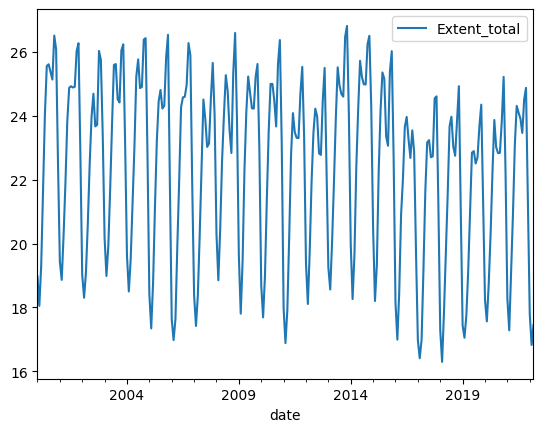

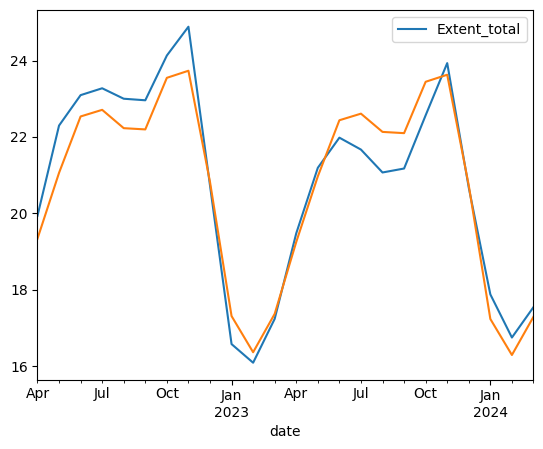

In [22]:
# create a cheeky plot
import matplotlib.pyplot as plt

train['2000':].plot()
test.plot()
y_pred.plot()
plt.show()

In [ ]:
# create prediction for next 10 years
y_pred = fit_model.forecast(144)


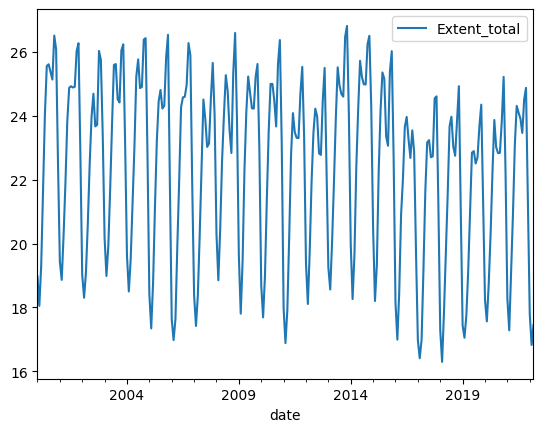

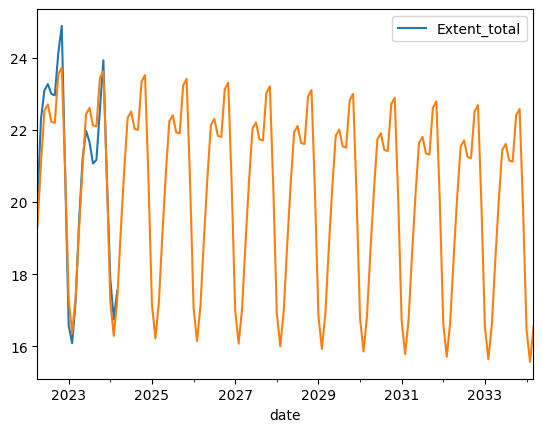

In [ ]:
# show example model

train['2000':].plot()
test.plot()
y_pred.plot()
plt.show()

In [ ]:
print(y_pred)

2022-04-30    19.335332
2022-05-31    21.059041
2022-06-30    22.535325
2022-07-31    22.708725
2022-08-31    22.228993
                ...    
2033-11-30    22.582920
2033-12-31    19.812010
2034-01-31    16.471340
2034-02-28    15.569701
2034-03-31    16.525827
Freq: M, Length: 144, dtype: float64


In [ ]:
# turn prediction series object into dataframe
forecast_df = pd.DataFrame(y_pred)
forecast_df.reset_index(inplace=True)

# Label the index column and rename the other column
forecast_df.rename(columns={'index': 'date', 0:'prediction'}, inplace=True)

In [ ]:
print(forecast_df)

         date  prediction
0  2022-04-30   19.335332
1  2022-05-31   21.059041
2  2022-06-30   22.535325
3  2022-07-31   22.708725
4  2022-08-31   22.228993
5  2022-09-30   22.196269
6  2022-10-31   23.547006
7  2022-11-30   23.732220
8  2022-12-31   20.820680
9  2023-01-31   17.310254
10 2023-02-28   16.362999
11 2023-03-31   17.368166
12 2023-04-30   19.250426
13 2023-05-31   20.966532
14 2023-06-30   22.436294
15 2023-07-31   22.608895
16 2023-08-31   22.131236
17 2023-09-30   22.098621
18 2023-10-31   23.443378
19 2023-11-30   23.627739
20 2023-12-31   20.728983
21 2024-01-31   17.233989
22 2024-02-29   16.290881
23 2024-03-31   17.291589


In [ ]:
# make 2D arrays so can compute linear regression
array_date = forecast_df['date'].values.reshape(-1, 1)
array_prediction = forecast_df['prediction'].values.reshape(-1,1)

In [ ]:
# create linear regression w/ forecast
from sklearn.linear_model import LinearRegression

regression_model_total = LinearRegression()
regression_model_total.fit(array_date, array_prediction)
slope = regression_model_total.coef_[0][0]

# Print the slope
print("Slope:", slope)

Slope: -3.6447099598010304e-17


In [ ]:
# that is a really really small number!
# though linear regression is obviously flawed,
# it seems as though sea ice will not hit zero any time soon